In [2]:
!pip install aeon

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from aeon.datasets import load_classification


def _parse_stocks(data, period, pred_days):
    N = data.size
    series = []
    outcomes = []

    for i in range(N - period - pred_days):
        series.append(data[i : i + period])

        outcome = np.sign(data[i + period + pred_days] - data[i + period])
        outcomes.append(outcome)

    X = np.array(series)
    y = np.array(outcomes)

    return X, y


def load_dataset(dataset_name: str, split_data=False, **kwargs):
    dataset_name = dataset_name.lower()

    if dataset_name == "heartbeat":
        X, y = load_classification("AbnormalHeartbeat")
        X = X.reshape(X.shape[0], X.shape[2])  # If we can handle multi-dimensional, remove this
    elif dataset_name == "japanese":
        X, y = load_classification("JapaneseVowels")
    elif dataset_name == "microsoft":
        data = np.genfromtxt("MSFT.csv", delimiter=",", skip_header=1, usecols=[1])
        X, y = _parse_stocks(data, kwargs.get("period", 60), kwargs.get("pred_days", 6))
    elif dataset_name == "amazon":
        data = np.genfromtxt("AMZN.csv", delimiter=",", skip_header=1, usecols=[1])
        X, y = _parse_stocks(data, kwargs.get("period", 60), kwargs.get("pred_days", 6))
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}.")

    if split_data:
        return train_test_split(X, y, test_size=0.2)
    return X, y


In [ ]:
# X, y = load_dataset("japanese")

In [5]:
# X[0]

In [72]:
X, y = load_dataset("amazon")

In [7]:
X.shape

(5022, 60)

In [8]:
!pip install tabulate

In [9]:
import pandas as pd

df = pd.read_csv("AMZN.csv")

print(df.head().to_markdown(index=False, numalign="left", stralign="left"))
print(df.info())

| Date      | Adj Close   |
|:----------|:------------|
| 5/15/1997 | 1.95833     |
| 5/16/1997 | 1.72917     |
| 5/19/1997 | 1.70833     |
| 5/20/1997 | 1.63542     |
| 5/21/1997 | 1.42708     |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5088 entries, 0 to 5087
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5088 non-null   object 
 1   Adj Close  5088 non-null   float64
dtypes: float64(1), object(1)
memory usage: 79.6+ KB
None


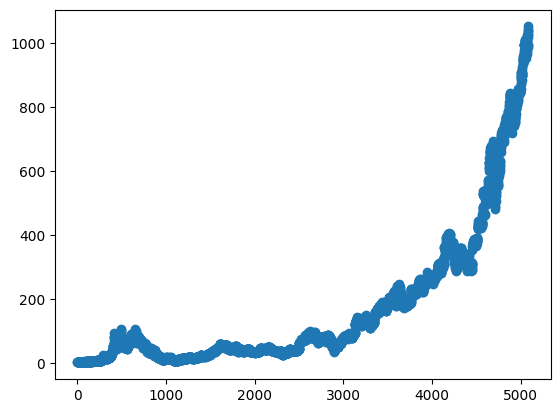

In [10]:
import matplotlib.pyplot as plt
plt.scatter(range(len(df['Adj Close'])), df['Adj Close'])

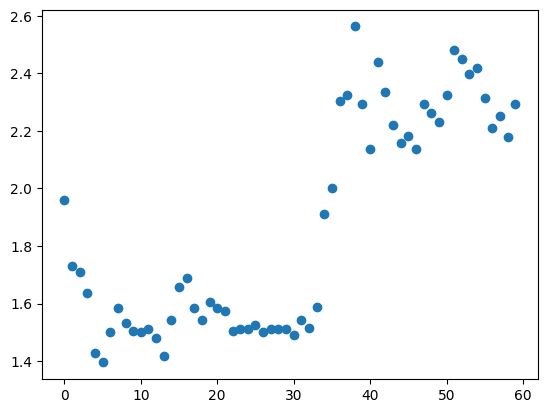

In [11]:
plt.scatter(range(60), X[0])
#each of these: a 60 day window of the stock data?

In [12]:
import pandas as pd
import numpy as np

def protected_log2(p):
  #debug this bc i'm pretty sure stuff still isn't working here.
  return np.where(p > 0, np.log2(p), 0) #replace w -inf?

def get_rolling_features(df, window_sizes):
  #rolling mean, std, autocorrelation with lag of 5 days, std of daily return.
  for window_size in window_sizes:
      #figure out how to make this fast
      window_str = str(window_size)

      df[f'r_mean_{window_str}'] = df['Adj Close'].rolling(window=window_size).mean()
      df[f'r_std_{window_str}'] = df['Adj Close'].rolling(window=window_size).std()

      df[f'lag5_corr_{window_str}'] = df['Adj Close'].rolling(window=window_size).corr(df['Adj Close'].shift(5))
      df[f'return_std_{window_str}'] = df['Daily_Return'].rolling(window=window_size).std()




In [13]:
df = pd.read_csv('AMZN.csv')
df.head()

,Date,Adj Close
0,5/15/1997,1.958333
1,5/16/1997,1.729167
2,5/19/1997,1.708333
3,5/20/1997,1.635417
4,5/21/1997,1.427083


In [14]:
def extract_and_save_features(ticker, window_sizes=[20,60], A_size=4):
    #ticker: AMZN, MSFT;
    #window_sizes: list containing the number of days for each window
    #A_size is number of symbols in dictionary

    input_filename = f'{ticker}.csv'
    output_filename = f'{ticker}_features.csv'

    #convert dates to datetime format, calculate daily return
    #hopefully adj close means what i think it does lol
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df['Daily_Return'] = df['Adj Close'].pct_change()

    get_rolling_features(df, window_sizes) #4 features per window size
    # get_symbolic_features(df, window_sizes, A=A_size)

    feature_cols = [col for col in df.columns if col not in ['Adj Close', 'Daily_Return']]
    df_features = df[feature_cols].dropna()

    print(f"features extracted: {df_features.shape[1]}")
    print(df_features.columns.tolist())

    df_features.to_csv(output_filename)


## TP 1 Stuff

In [15]:
!pip install dtw-python

In [16]:
!pip install alphacsc

In [17]:
from dtw import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [18]:
from itertools import tee

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

import numpy as np
import pandas as pd

from aeon.datasets import load_classification
from dtw import dtw
import time
from scipy.cluster import hierarchy
from scipy.stats import f_oneway


from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import adjusted_rand_score, make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector

from alphacsc import learn_d_z
try:
    from alphacsc.utils import construct_X
except:
    from alphacsc.utils.convolution import construct_X

from scipy.signal import argrelmax

In [19]:
word_1 = X[0]
word_2 = X[1]

In [20]:
query = X[0]
template = X[60]
alignment = dtw(query, template, keep_internals=True)

dtw_distance = alignment.distance

print(f"DTW Distance: {dtw_distance}")

DTW Distance: 93.87500000000003


<Axes: >

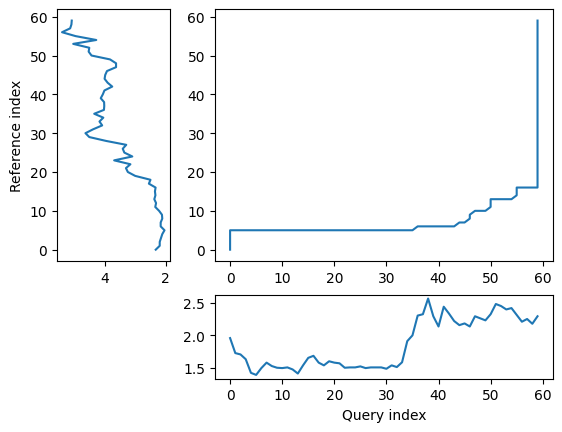

In [21]:
alignment.plot(type="threeway")

In [22]:
def get_dtw_distance(signal_1,signal_2):
    alignment = dtw(signal_1, signal_2, keep_internals=True)
    return alignment.distance

def get_euclidean_distance(signal_1,signal_2):
    return np.linalg.norm(signal_1 - signal_2)

In [23]:
profiles = X

In [24]:
profiles_sub = X[0:10]
profiles_sub

array([[1.958333, 1.729167, 1.708333, 1.635417, 1.427083, 1.395833,
        1.5     , 1.583333, 1.53125 , 1.505208, 1.5     , 1.510417,
        1.479167, 1.416667, 1.541667, 1.65625 , 1.6875  , 1.583333,
        1.541667, 1.604167, 1.583333, 1.572917, 1.505208, 1.510417,
        1.510417, 1.526042, 1.5     , 1.510417, 1.510417, 1.510417,
        1.489583, 1.541667, 1.515625, 1.588542, 1.911458, 2.      ,
        2.302083, 2.322917, 2.5625  , 2.291667, 2.135417, 2.4375  ,
        2.333333, 2.21875 , 2.15625 , 2.182292, 2.135417, 2.291667,
        2.260417, 2.229167, 2.322917, 2.479167, 2.447917, 2.395833,
        2.416667, 2.3125  , 2.208333, 2.25    , 2.177083, 2.291667],
       [1.729167, 1.708333, 1.635417, 1.427083, 1.395833, 1.5     ,
        1.583333, 1.53125 , 1.505208, 1.5     , 1.510417, 1.479167,
        1.416667, 1.541667, 1.65625 , 1.6875  , 1.583333, 1.541667,
        1.604167, 1.583333, 1.572917, 1.505208, 1.510417, 1.510417,
        1.526042, 1.5     , 1.510417, 1.510417,

In [25]:
def display_distance_matrix_as_table(
    distance_matrix, labels=None, figsize=(8, 2)
):
#only using this one afaik
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("tight")
    ax.axis("off")
    norm = mpl.colors.Normalize()
    cell_colours_hex = np.empty(shape=distance_matrix.shape, dtype=object)
    cell_colours_rgba = plt.get_cmap("magma")(norm(distance_matrix))

    for i in range(distance_matrix.shape[0]):
        for j in range(i + 1, distance_matrix.shape[0]):
            cell_colours_hex[i, j] = rgb2hex(
                cell_colours_rgba[i, j], keep_alpha=True
            )
            cell_colours_hex[j, i] = cell_colours_hex[i, j]

    if labels is not None:
        _ = ax.table(
            cellText=distance_matrix,
            colLabels=labels,
            rowLabels=labels,
            loc="center",
            cellColours=cell_colours_hex,
        )
    else:
        _ = ax.table(
            cellText=distance_matrix,
            loc="center",
            cellColours=cell_colours_hex,
        )

    return ax

def plot_CDL(signal, Z, D, figsize=(15, 10)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
        plt.plot(Z[:, i])
        plt.ylim((np.min(Z), np.max(Z)))

def get_n_largest(
    arr: np.ndarray, n_largest: int = 3) -> (np.ndarray, np.ndarray):
    """Return the n largest values and associated indexes of an array.

    (In decreasing order of value.)
    """
    indexes = np.argsort(arr)[-n_largest:][::-1]
    if n_largest == 1:
        indexes = np.array(indexes)
    values = np.take(arr, indexes)
    return values, indexes

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def get_largest_local_max(signal1D: np.ndarray, order: int = 1):
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_index = all_local_max_indexes[all_local_max.argsort()[-1]]

    return signal1D[largest_local_max_index], largest_local_max_index

In [26]:
# init
distance_matrix = np.zeros(
    (profiles_sub.shape[0], profiles_sub.shape[0]), dtype=float
)

for row in range(profiles_sub.shape[0]):
    for col in range(row + 1, profiles_sub.shape[0]):
        distance_matrix[row, col] = get_dtw_distance(
            profiles_sub[row], profiles_sub[col]
        )
        distance_matrix[col, row] = distance_matrix[row, col]

In [27]:
import matplotlib as mpl
from matplotlib.colors import rgb2hex


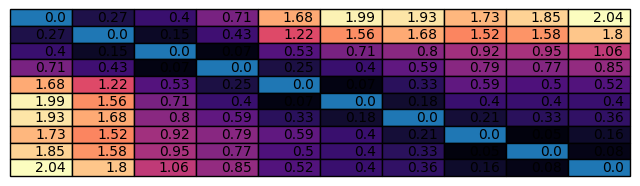

In [28]:
_ = display_distance_matrix_as_table(
    np.round(distance_matrix, 2)
)

In [29]:
euclidean_distance_matrix= np.zeros((profiles_sub.shape[0], profiles_sub.shape[0]), dtype=float)
for row in range(profiles_sub.shape[0]):
    for col in range(row + 1, profiles_sub.shape[0]):
        euclidean_distance_matrix[row, col] = get_euclidean_distance(profiles_sub[row], profiles_sub[col])
        euclidean_distance_matrix[col, row] = euclidean_distance_matrix[row, col]

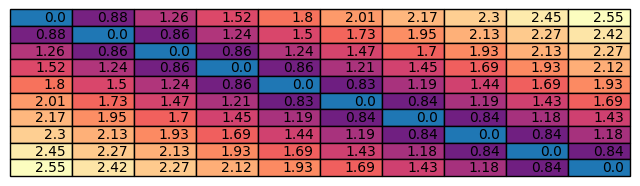

In [30]:
_ = display_distance_matrix_as_table(
    np.round(euclidean_distance_matrix, 2)
)

Get Features (From TP1)

In [31]:
from scipy.stats import skew, kurtosis

def get_distribution_features(signal: np.ndarray) -> dict:
    res_dict = dict()
    res_dict["mean"] = signal.mean()
    res_dict["std"] = signal.std()
    res_dict["min"] = signal.min()
    res_dict["max"] = signal.max()
    res_dict["skew"] = skew(signal)
    res_dict["kurtosis"] = kurtosis(signal)
    res_dict["25%"] = np.percentile(signal, 25)
    res_dict["50%"] = np.percentile(signal, 50)
    res_dict["75%"] = np.percentile(signal, 75)
    return res_dict

In [32]:
FREQUENCY = 2000
signal = X[0]


from scipy.fft import rfft, rfftfreq

def get_fourier_features(signal: np.ndarray, n_bins: int = 100) -> dict:
    """The signal is assumed to be centered and scaled to unit variance."""
    n_samples = signal.shape[0]
    fourier = abs(rfft(signal))
    freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)
    res_dict = dict()

    freq_bins = np.linspace(0, FREQUENCY / 2, n_bins + 1)
    for f_min, f_max in pairwise(freq_bins):
        keep = (f_min <= freqs) & (freqs < f_max)
        res_dict[f"fourier_{f_min:.0f}-{f_max:.0f}_Hz"] = np.log(
            np.sum(fourier[keep] ** 2)
        )
    return res_dict

In [33]:
from statsmodels.tsa.stattools import acf

def samples_to_hz(lag_in_samples, FREQUENCY):
    return FREQUENCY / lag_in_samples

def get_autocorr_features(signal: np.ndarray, n_lags: int = 200) -> dict:
    auto_corr = acf(signal, nlags=n_lags, fft=True)
    res_dict = dict()
    for lag, auto_corr_value in enumerate(auto_corr):
        res_dict[f"autocorrelation_{lag}_lag"] = auto_corr_value

    local_max, local_argmax = get_largest_local_max(auto_corr[1:], order=10)
    local_argmax += 1  # to account for the lag=0 removed before
    local_min, local_argmin = get_largest_local_max(-auto_corr[1:], order=10)
    local_min = -local_min
    local_argmin += 1  # to account for the lag=0 removed before
    res_dict["largest_local_max_autocorrelation"] = local_max
    res_dict["lag_largest_local_max_autocorrelation_Hz"] = samples_to_hz(local_argmax, FREQUENCY)
    res_dict["largest_local_min_autocorrelation"] = local_min
    res_dict["lag_largest_local_min_autocorrelation_Hz"] = samples_to_hz(local_argmin, FREQUENCY)
    return res_dict

In [34]:
def get_features(signal: np.ndarray) -> dict:
    res_dict = dict()

    # stats
    res_dict.update(get_distribution_features(signal))

    # spectral
    signal -= signal.mean()
    signal /= signal.std()
    res_dict.update(get_fourier_features(signal, n_bins=50))

    # autocorrelation
    res_dict.update(get_autocorr_features(signal, n_lags=200))

    return res_dict

In [35]:
# get_autocorr_features(signal, n_lags=200)

In [36]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import rfft, rfftfreq
from statsmodels.tsa.stattools import acf
from scipy.signal import argrelmax
from itertools import tee

In [37]:
def samples_to_hz(lag_in_samples, FREQUENCY):
    # This function is not strictly needed for the stock data which doesn't have a defined Hz,
    # but we'll keep it for structural completeness.
    return FREQUENCY / lag_in_samples if lag_in_samples > 0 else 0

In [38]:
def get_largest_local_max(signal1D: np.ndarray, order: int = 1):
    """
    Return the largest local max and the associated index in a tuple.
    Safely handles cases where no local maxima are found.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]

    if all_local_max_indexes.size == 0:
        return np.nan, np.nan

    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_index = all_local_max_indexes[np.argmax(all_local_max)]

    return signal1D[largest_local_max_index], largest_local_max_index

In [39]:
def get_distribution_features(signal: np.ndarray) -> dict:
    """Extract standard distribution features."""
    res_dict = dict()

    if signal.size == 0:
        return {f: np.nan for f in ["mean", "std", "min", "max", "skew", "kurtosis", "25%", "50%", "75%"]}

    res_dict["mean"] = signal.mean()
    res_dict["std"] = signal.std()
    res_dict["min"] = signal.min()
    res_dict["max"] = signal.max()
    res_dict["skew"] = skew(signal)
    res_dict["kurtosis"] = kurtosis(signal)
    res_dict["25%"] = np.percentile(signal, 25)
    res_dict["50%"] = np.percentile(signal, 50)
    res_dict["75%"] = np.percentile(signal, 75)
    return res_dict


In [40]:
def get_fourier_features(signal: np.ndarray, n_bins: int = 100, FREQUENCY: int = 2000) -> dict:
    """
    Extract spectral features by binning the power spectrum of the FFT.
    The signal is assumed to be centered and scaled to unit variance.
    """
    n_samples = signal.shape[0]
    if n_samples == 0:
         return {f"fourier_{i}-{i+1}_Hz": np.nan for i in range(n_bins)}

    fourier = abs(rfft(signal))
    freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)
    res_dict = dict()

    freq_bins = np.linspace(0, FREQUENCY / 2, n_bins + 1)

    def safe_log(arr):
        return np.log(np.where(arr > 0, arr, 1e-10))

    for f_min, f_max in pairwise(freq_bins):
        keep = (f_min <= freqs) & (freqs < f_max)

        power = np.sum(fourier[keep] ** 2)
        res_dict[f"fourier_{f_min:.0f}-{f_max:.0f}_Hz"] = safe_log(power)

    return res_dict


In [41]:
def get_autocorr_features(signal: np.ndarray, n_lags: int = 200, order: int = 10, FREQUENCY: int = 2000) -> dict:
    """
    Extract features from the autocorrelation function.
    Safely handles finding local max/min by returning NaN if none are found.
    """
    res_dict = dict()
    n_samples = signal.shape[0]

    max_lag = min(n_samples - 1, n_lags)
    if max_lag <= 0:
        return res_dict

    auto_corr = acf(signal, nlags=max_lag, fft=True)

    for lag, auto_corr_value in enumerate(auto_corr):
        res_dict[f"autocorrelation_{lag}_lag"] = auto_corr_value

    local_max, local_argmax_index = get_largest_local_max(auto_corr[1:], order=order)

    if np.isnan(local_max):
        # no local max found
        res_dict["largest_local_max_autocorrelation"] = 0
        res_dict["lag_largest_local_max_autocorrelation_Hz"] = np.nan
    else:
        local_argmax = local_argmax_index + 1
        res_dict["largest_local_max_autocorrelation"] = local_max
        res_dict["lag_largest_local_max_autocorrelation_Hz"] = samples_to_hz(local_argmax, FREQUENCY)

    local_min_neg, local_argmin_index = get_largest_local_max(-auto_corr[1:], order=order)

    if np.isnan(local_min_neg):
        # no local minimum found
        res_dict["largest_local_min_autocorrelation"] = 0
        res_dict["lag_largest_local_min_autocorrelation_Hz"] = np.nan
    else:
        # local_argmin_index is relative to auto_corr[1:], so add 1 for true lag
        local_argmin = local_argmin_index + 1
        res_dict["largest_local_min_autocorrelation"] = -local_min_neg
        res_dict["lag_largest_local_min_autocorrelation_Hz"] = samples_to_hz(local_argmin, FREQUENCY)

    return res_dict

In [ ]:
def get_features(signal: np.ndarray, FREQUENCY: int = 2000, N_FOURIER_BINS: int = 50, N_LAGS: int = 60) -> dict:
    """
    Extract a comprehensive set of features from a single time series signal.
    """
    res_dict = dict()

    res_dict.update(get_distribution_features(signal))

    scaled_signal = signal.copy()

    if scaled_signal.std() > 1e-10:
        scaled_signal -= scaled_signal.mean()
        scaled_signal /= scaled_signal.std()
    else:
        fourier_features = {f"fourier_{f_min:.0f}-{f_max:.0f}_Hz": 0 for f_min, f_max in pairwise(np.linspace(0, FREQUENCY / 2, N_FOURIER_BINS + 1))}
        res_dict.update(fourier_features)

        autocorr_features = {f"autocorrelation_{lag}_lag": 0 for lag in range(N_LAGS + 1)}
        autocorr_features["largest_local_max_autocorrelation"] = 0
        autocorr_features["lag_largest_local_max_autocorrelation_Hz"] = np.nan
        autocorr_features["largest_local_min_autocorrelation"] = 0
        autocorr_features["lag_largest_local_min_autocorrelation_Hz"] = np.nan
        res_dict.update(autocorr_features)

        return res_dict


    res_dict.update(get_fourier_features(scaled_signal, n_bins=N_FOURIER_BINS, FREQUENCY=FREQUENCY))

    res_dict.update(get_autocorr_features(scaled_signal, n_lags=N_LAGS, order=10, FREQUENCY=FREQUENCY))

    return res_dict

In [43]:
FREQUENCY_DUMMY = 2000
N_LAG_FEATURES = 59 # max lag for a 60-point series is 59

In [44]:
X.shape

(5022, 60)

In [45]:
features = [get_features(X[i]) for i in range(X.shape[0])]

In [46]:
X

array([[   1.958333,    1.729167,    1.708333, ...,    2.25    ,
           2.177083,    2.291667],
       [   1.729167,    1.708333,    1.635417, ...,    2.177083,
           2.291667,    2.328125],
       [   1.708333,    1.635417,    1.427083, ...,    2.291667,
           2.328125,    2.197917],
       ...,
       [ 909.289978,  918.380005,  924.98999 , ..., 1024.449951,
        1026.869995, 1028.699951],
       [ 918.380005,  924.98999 ,  948.22998 , ..., 1026.869995,
        1028.699951, 1025.670044],
       [ 924.98999 ,  948.22998 ,  946.940002, ..., 1028.699951,
        1025.670044, 1038.949951]], shape=(5022, 60))

In [47]:
def get_rolling_features_refactored(X, window_size):
  # window_size = X.shape[1]
  res_list = []

  for signal in X:
    res_dict = {}
    res_dict['r_mean'] = np.mean(X)
    res_dict['r_std'] = np.std(X)
    res_dict['return_std'] = np.std(np.divide(X[0:-1], X[1:]))

    res_list.append(res_dict)
  return res_list

In [48]:
rfr = get_rolling_features_refactored(X, 60)

In [49]:
rfr_df = pd.DataFrame(rfr)

In [50]:
rfr_df

,r_mean,r_std,return_std
0,165.214889,210.185958,0.038299
1,165.214889,210.185958,0.038299
2,165.214889,210.185958,0.038299
3,165.214889,210.185958,0.038299
4,165.214889,210.185958,0.038299
...,...,...,...
5017,165.214889,210.185958,0.038299
5018,165.214889,210.185958,0.038299
5019,165.214889,210.185958,0.038299
5020,165.214889,210.185958,0.038299


In [51]:
all_features = pd.DataFrame(features)

In [52]:
rfr_df['r_mean'] - all_features['mean']
#this confuses me because i'd thought they were the exact same metric

0       163.349177
1       163.343014
2       163.335202
3       163.327042
4       163.318361
           ...    
5017   -808.423275
5018   -810.414275
5019   -812.432275
5020   -814.371942
5021   -816.381442
Length: 5022, dtype: float64

In [53]:
new_all_features = pd.merge(rfr_df, all_features, left_index=True, right_index = True)

In [54]:
new_all_features.columns

Index(['r_mean', 'r_std', 'return_std', 'mean', 'std', 'min', 'max', 'skew',
       'kurtosis', '25%',
       ...
       'autocorrelation_54_lag', 'autocorrelation_55_lag',
       'autocorrelation_56_lag', 'autocorrelation_57_lag',
       'autocorrelation_58_lag', 'autocorrelation_59_lag',
       'largest_local_max_autocorrelation',
       'lag_largest_local_max_autocorrelation_Hz',
       'largest_local_min_autocorrelation',
       'lag_largest_local_min_autocorrelation_Hz'],
      dtype='object', length=126)

In [55]:
#dropping low variance features:
variance_threshold = 0.1

low_variance_features = all_features.std() < variance_threshold
low_variance_features = low_variance_features[
    low_variance_features
].index.to_numpy()
print(f"There are {len(low_variance_features)} features to drop.")
print(low_variance_features)



There are 28 features to drop.
['fourier_40-60_Hz' 'fourier_80-100_Hz' 'fourier_140-160_Hz'
 'fourier_180-200_Hz' 'fourier_240-260_Hz' 'fourier_280-300_Hz'
 'fourier_340-360_Hz' 'fourier_380-400_Hz' 'fourier_440-460_Hz'
 'fourier_480-500_Hz' 'fourier_540-560_Hz' 'fourier_580-600_Hz'
 'fourier_640-660_Hz' 'fourier_680-700_Hz' 'fourier_740-760_Hz'
 'fourier_780-800_Hz' 'fourier_840-860_Hz' 'fourier_880-900_Hz'
 'fourier_940-960_Hz' 'fourier_980-1000_Hz' 'autocorrelation_0_lag'
 'autocorrelation_1_lag' 'autocorrelation_55_lag' 'autocorrelation_56_lag'
 'autocorrelation_57_lag' 'autocorrelation_58_lag'
 'autocorrelation_59_lag' 'largest_local_min_autocorrelation']


In [56]:
all_features.drop(columns=low_variance_features, inplace=True, errors="ignore")
print(f"There are {all_features.shape[1]} features left.")

There are 95 features left.


In [57]:
all_features.std().sort_values()

autocorrelation_2_lag                  0.100610
largest_local_max_autocorrelation      0.100933
autocorrelation_54_lag                 0.109492
autocorrelation_53_lag                 0.119810
autocorrelation_52_lag                 0.127948
                                        ...    
25%                                  202.713855
mean                                 209.654776
50%                                  209.685344
75%                                  217.274579
max                                  226.181622
Length: 95, dtype: float64

In [58]:
features_to_check = ['kurtosis','lag_largest_local_min_autocorrelation_Hz','lag_largest_local_max_autocorrelation_Hz']

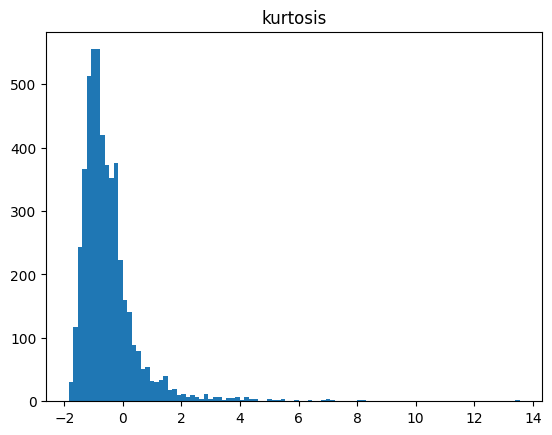

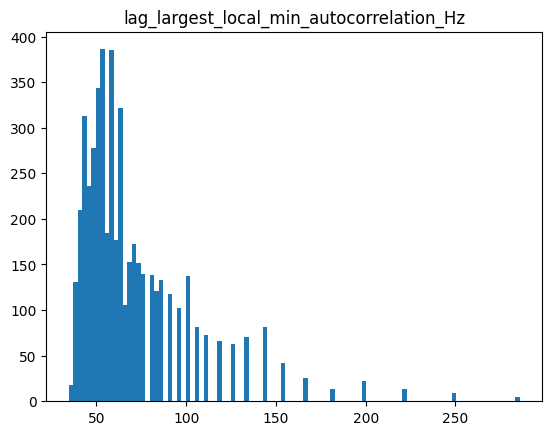

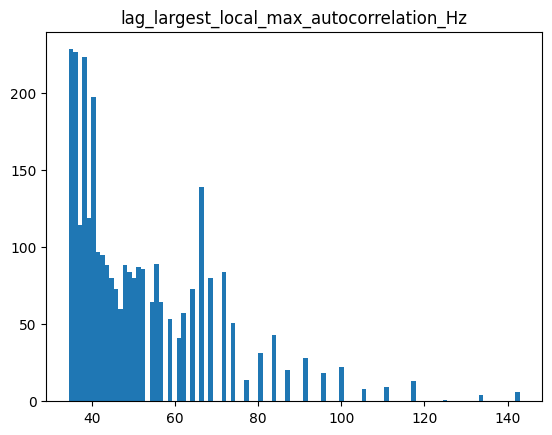

In [59]:
for feature in features_to_check:
    plt.hist(all_features[feature], bins=100)
    plt.title(feature)
    plt.plot()
    plt.show()

#skipping outlier management bit

In [60]:
# Assuming your DataFrame is named df
# Create a boolean Series: True if ANY column in the row is NaN
rows_with_nan = all_features.isna().any(axis=1)

# Filter the DataFrame to show only those rows
df_only_nans = all_features[rows_with_nan]
print(df_only_nans)

            mean        std         min          max      skew  kurtosis  \
0       1.865712   0.375236    1.395833     2.562500  0.334552 -1.587510   
1       1.871875   0.379717    1.395833     2.562500  0.304008 -1.637733   
2       1.879688   0.381519    1.395833     2.562500  0.249556 -1.677674   
3       1.887847   0.382999    1.395833     2.562500  0.193802 -1.709965   
4       1.896528   0.383082    1.395833     2.562500  0.136187 -1.725629   
...          ...        ...         ...          ...       ...       ...   
5010  961.178499  34.638371  884.669983  1011.340027 -0.526947 -0.756341   
5011  962.849166  33.874454  884.669983  1011.340027 -0.575165 -0.653733   
5012  964.673499  32.536014  898.530029  1011.340027 -0.571464 -0.675230   
5013  966.415500  31.925572  898.530029  1011.340027 -0.605074 -0.576610   
5014  968.029666  31.157029  898.530029  1011.340027 -0.649047 -0.458093   

             25%         50%         75%  fourier_0-20_Hz  ...  \
0       1.510417    1

In [61]:
all_features_test = all_features.drop(columns=['lag_largest_local_max_autocorrelation_Hz'])


In [62]:
# df_only_nans = all_features_test[rows_with_nan]
# print(df_only_nans)

In [63]:
nan_columns_list = all_features.columns[all_features.isna().any(axis=0)]

print(nan_columns_list)

Index(['lag_largest_local_max_autocorrelation_Hz'], dtype='object')


In [64]:
all_features_centered = all_features_test.to_numpy()

all_features_centered -= all_features_centered.mean(axis=0)
all_features_centered /= all_features_centered.std(axis=0)


pca = PCA(n_components=2).fit(all_features_centered)
#pca works after dropping that column; figure out why it's always nan later

In [65]:
# select the 10 most important features (with highest norm).
top_features_for_pca = np.linalg.norm(pca.components_, axis=0).argsort()[-10:]

for feature_ind in top_features_for_pca:
    msg = f"{all_features.columns[feature_ind]}: {(pca.components_.T[feature_ind]**2).sum():.3f}"
    print(msg)

autocorrelation_48_lag: 0.041
autocorrelation_49_lag: 0.041
autocorrelation_30_lag: 0.041
autocorrelation_29_lag: 0.044
autocorrelation_23_lag: 0.044
autocorrelation_28_lag: 0.047
autocorrelation_24_lag: 0.047
autocorrelation_27_lag: 0.048
autocorrelation_25_lag: 0.049
autocorrelation_26_lag: 0.049


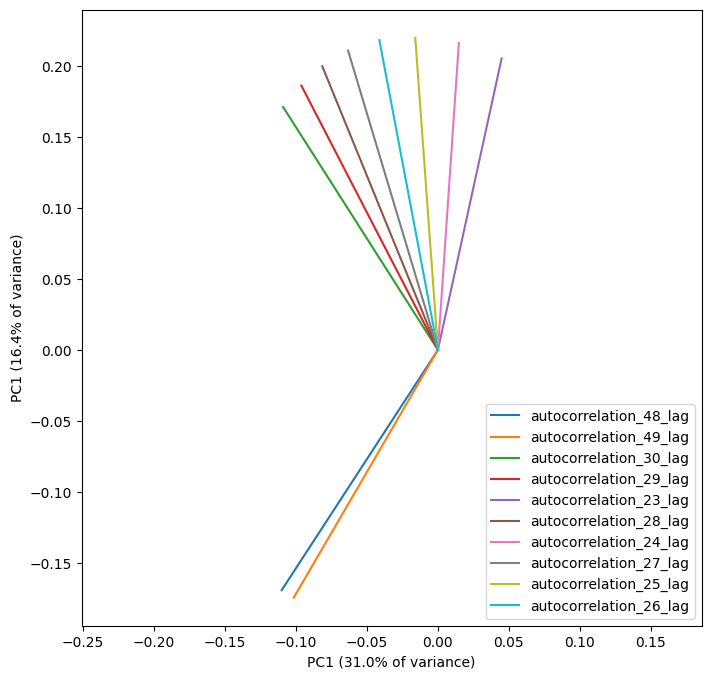

In [66]:
# plot the 2D projection of the top 10 features
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis("equal")
for feature_ind in top_features_for_pca:  # normaliser par la variance
    dx, dy = pca.components_.T[feature_ind]
    ax.plot([0, dx], [0, dy], label=all_features.columns[feature_ind])
ax.set_xlabel(f"PC1 ({pca.explained_variance_[0]:.1f}% of variance)")
ax.set_ylabel(f"PC1 ({pca.explained_variance_[1]:.1f}% of variance)")
_ = plt.legend()

In [67]:
variance_threshold = 0.8

In [68]:
variance_threshold = 0.8

for i in range(3, 20):
    pca = PCA(n_components=i).fit(all_features_centered)
    print(f"Number of components: {i}, Explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    if pca.explained_variance_ratio_.sum() >= variance_threshold:
        break

Number of components: 3, Explained variance: 0.574
Number of components: 4, Explained variance: 0.628
Number of components: 5, Explained variance: 0.669
Number of components: 6, Explained variance: 0.691
Number of components: 7, Explained variance: 0.707
Number of components: 8, Explained variance: 0.720
Number of components: 9, Explained variance: 0.733
Number of components: 10, Explained variance: 0.746
Number of components: 11, Explained variance: 0.758
Number of components: 12, Explained variance: 0.769
Number of components: 13, Explained variance: 0.779
Number of components: 14, Explained variance: 0.790
Number of components: 15, Explained variance: 0.800
Number of components: 16, Explained variance: 0.810


Text(0, 0.5, 'Cumulative explained variance')

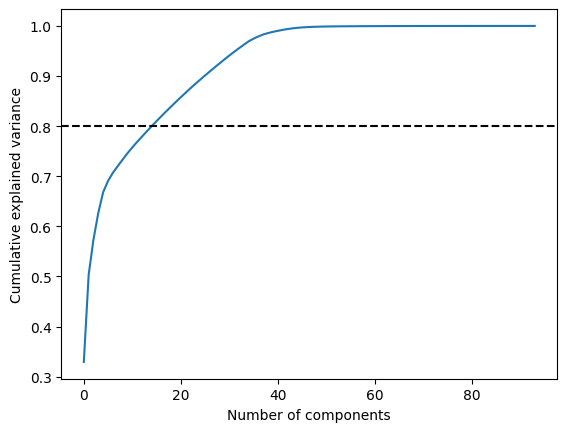

In [69]:
variance_threshold = 0.8
pca= PCA().fit(all_features_centered)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.axhline(variance_threshold, ls="--", color="k")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")

Supervised Selection

In [70]:
pd.Series(y).value_counts()

 1.0    2709
-1.0    2304
 0.0       9
Name: count, dtype: int64

Testing on Heartbeat data


In [73]:
X_h, y_h = load_dataset("heartbeat")


In [74]:
X_h.shape


(409, 18530)

In [75]:
feature_h = get_features(X_h[0])


In [ ]:
#modify the above code block, ensuring that you had the right frequency. 
# #def get_features(signal: np.ndarray, FREQUENCY: int = 2000, 
#N_FOURIER_BINS: int = 50, N_LAGS: int = 60) -> dict:



In [ ]:
features_h = [get_features(X_h[i]) for i in range(X_h.shape[0])]
#

In [79]:
df_h = pd.DataFrame(features_h)
df_h


,mean,std,min,max,skew,kurtosis,25%,50%,75%,fourier_0-20_Hz,...,autocorrelation_55_lag,autocorrelation_56_lag,autocorrelation_57_lag,autocorrelation_58_lag,autocorrelation_59_lag,autocorrelation_60_lag,largest_local_max_autocorrelation,lag_largest_local_max_autocorrelation_Hz,largest_local_min_autocorrelation,lag_largest_local_min_autocorrelation_Hz
0,-0.000044,0.053476,-0.325073,0.291504,0.286963,4.395775,-0.027130,-0.000610,0.025116,17.425511,...,0.037710,0.027325,0.014352,-0.001019,-0.018532,-0.037809,0.052597,38.461538,-0.379260,71.428571
1,-0.000026,0.021232,-0.109467,0.139496,0.389185,4.207598,-0.011505,-0.000244,0.010864,17.947738,...,-0.211143,-0.198391,-0.185622,-0.173173,-0.161435,-0.150685,0.000000,NaN,-0.275819,43.478261
2,-0.000069,0.034245,-0.253387,0.291596,1.362185,22.093219,-0.007721,-0.000031,0.007477,15.761979,...,0.089758,0.081962,0.073401,0.064277,0.054830,0.045265,0.113092,40.816327,-0.542523,95.238095
3,-0.000026,0.075533,-0.440369,0.644653,1.424710,15.069250,-0.020012,-0.000275,0.018646,15.773631,...,0.069344,0.082855,0.096318,0.109325,0.121486,0.132459,0.000000,NaN,-0.451949,95.238095
4,-0.000021,0.126608,-1.000000,0.999969,0.238795,20.218365,-0.017639,0.000275,0.016685,15.738893,...,0.279423,0.271350,0.259040,0.242855,0.223255,0.200778,0.283012,37.037037,-0.571900,86.956522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,-0.000028,0.067211,-0.550110,0.783569,1.245840,30.545004,-0.012085,-0.000397,0.011749,15.589544,...,0.294224,0.283896,0.267643,0.245868,0.219117,0.188050,0.298364,37.037037,-0.497214,95.238095
405,0.000003,0.064658,-0.479858,0.353424,-0.524989,5.859288,-0.029083,0.001282,0.030029,17.698791,...,-0.094410,-0.081077,-0.068372,-0.056857,-0.046842,-0.038808,0.000000,NaN,-0.212136,47.619048
406,0.000012,0.048458,-0.481262,0.304291,-1.250202,16.034519,-0.017487,-0.000061,0.017334,16.237108,...,0.143441,0.160147,0.175399,0.189062,0.200975,0.210788,0.000000,NaN,-0.418884,68.965517
407,0.000035,0.034648,-0.301331,0.286865,-0.699097,15.258245,-0.011841,-0.000061,0.011932,16.806250,...,0.034216,0.051799,0.065877,0.076914,0.085422,0.091822,0.000000,NaN,-0.304064,58.823529


In [80]:
def find_low_variance_features(all_features, variance_threshold=0.1):
    #dropping low variance features:

    low_variance_features = all_features.std() < variance_threshold
    low_variance_features = low_variance_features[
        low_variance_features
    ].index.to_numpy()
    print(f"There are {len(low_variance_features)} features to drop.")
    print(low_variance_features)

    return low_variance_features

In [ ]:
def drop_low_variance_features(all_features, variance_threshold=0.1):
    features_to_drop = find_low_variance_features(all_features, variance_threshold=variance_threshold)
    all_features.drop(columns=features_to_drop, inplace=True, errors="ignore")
    print(f"There are {df_h.shape[1]} features left.")

In [82]:
lvf_h = find_low_variance_features(df_h)


There are 10 features to drop.
['mean' 'std' '25%' '50%' '75%' 'autocorrelation_0_lag'
 'autocorrelation_1_lag' 'autocorrelation_2_lag' 'autocorrelation_3_lag'
 'autocorrelation_4_lag']


In [ ]:
df_h.drop(columns=lvf_h, inplace=True, errors="ignore")
print(f"There are {df_h.shape[1]} features left.")

There are 114 features left.


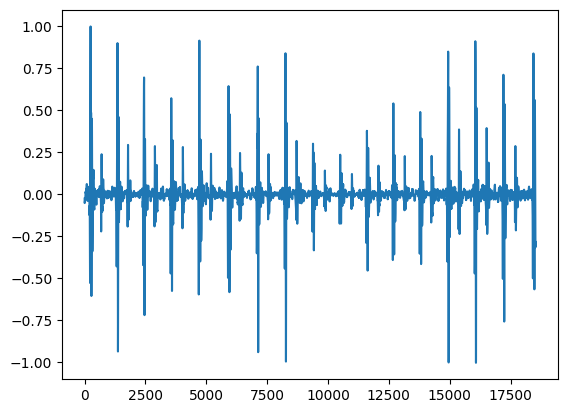

In [92]:
sample = X_h[4]
plt.plot(range(len(sample)), sample)
plt.show()


PCA on Heartbeat Data

In [ ]:
def center_and_pca(all_features_centered, n_components=2):
    #bake in test for nan
    all_features_centered = all_features_test.to_numpy()

    all_features_centered -= all_features_centered.mean(axis=0)
    all_features_centered /= all_features_centered.std(axis=0)


    pca = PCA(n_components=n_components).fit(all_features_centered)
    return pca
    #pca works after dropping that column; figure out why it's always nan later

In [94]:
pca_h = center_and_pca(df_h)
pca_h


,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [95]:
# select the 10 most important features (with highest norm).
top_features_for_pca_h = np.linalg.norm(pca_h.components_, axis=0).argsort()[-10:]

for feature_ind in top_features_for_pca_h:
    msg = f"{all_features.columns[feature_ind]}: {(pca_h.components_.T[feature_ind]**2).sum():.3f}"
    print(msg)

autocorrelation_48_lag: 0.041
autocorrelation_49_lag: 0.041
autocorrelation_30_lag: 0.041
autocorrelation_29_lag: 0.044
autocorrelation_23_lag: 0.044
autocorrelation_28_lag: 0.047
autocorrelation_24_lag: 0.047
autocorrelation_27_lag: 0.048
autocorrelation_25_lag: 0.049
autocorrelation_26_lag: 0.049
